In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data = pd.read_csv('../dataset/job_postings_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                20000 non-null  int64 
 1   time              20000 non-null  int64 
 2   city              20000 non-null  object
 3   job               20000 non-null  object
 4   number_employees  20000 non-null  int64 
 5   major             20000 non-null  object
 6   level             20000 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


In [571]:
data.head(10)

,id,time,city,job,number_employees,major,level
0,1,1695908160000,Hà Nội,ReactJs,1,Công nghệ thông tin,fresher
1,2,1685487066000,Hồ Chí Minh,Backend Developer,2,Công nghệ thông tin,fresher
2,3,1689072962000,Hồ Chí Minh,NodeJs,2,Công nghệ thông tin,senior
3,4,1714943190000,Hồ Chí Minh,DevOps Engineer,2,Công nghệ thông tin,fresher
4,5,1683174806000,Hà Nội,Frontend Developer,2,Công nghệ thông tin,senior
5,6,1677120936000,Hồ Chí Minh,Python Developer,3,Công nghệ thông tin,junior
6,7,1695921879000,Hồ Chí Minh,DevOps Engineer,2,Công nghệ thông tin,senior
7,8,1683552476000,Hà Nội,Python Developer,1,Công nghệ thông tin,intern
8,9,1676637659000,Hồ Chí Minh,Backend Developer,1,Công nghệ thông tin,senior
9,10,1683103577000,Hồ Chí Minh,DevOps Engineer,3,Công nghệ thông tin,middle


In [2]:
# Chuyển đổi cột 'time' từ Unix timestamp sang datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')

# Thêm cột 'month' để tổng hợp theo tháng
data['month'] = data['time'].dt.to_period('M')

# Tổng hợp dữ liệu theo 'job', 'city', 'month'
aggregated_data = data.groupby(['job', 'city', 'month']).size().reset_index(name='job_postings_count')

# Kiểm tra dữ liệu sau khi tổng hợp
print(aggregated_data.head())

                 job    city    month  job_postings_count
0  Backend Developer  Hà Nội  2023-01                  57
1  Backend Developer  Hà Nội  2023-02                  45
2  Backend Developer  Hà Nội  2023-03                  39
3  Backend Developer  Hà Nội  2023-04                  43
4  Backend Developer  Hà Nội  2023-05                  37


In [3]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   job                 578 non-null    object   
 1   city                578 non-null    object   
 2   month               578 non-null    period[M]
 3   job_postings_count  578 non-null    int64    
dtypes: int64(1), object(2), period[M](1)
memory usage: 18.2+ KB


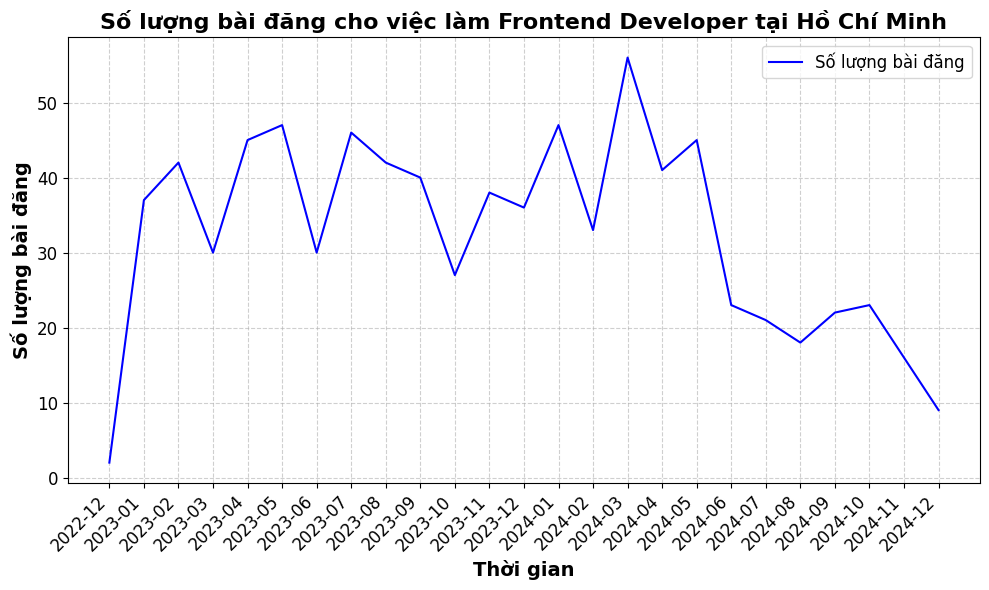

In [5]:
def plot_job_trend(job, city):
    job_data = aggregated_data[(aggregated_data['job'] == job) & (aggregated_data['city'] == city)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(job_data['month'].astype(str), job_data['job_postings_count'], linestyle='-', color='b', label='Số lượng bài đăng')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('Thời gian', fontsize=14, fontweight='bold')
    plt.ylabel('Số lượng bài đăng', fontsize=14, fontweight='bold')
    plt.title(f'Số lượng bài đăng cho việc làm {job} tại {city}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_job_trend('Frontend Developer', 'Hồ Chí Minh')

In [575]:
# Chuẩn hóa cột 'job_postings_count'
scaler = MinMaxScaler(feature_range=(0, 1))
aggregated_data["job_postings_count_scaled"] = scaler.fit_transform(
    aggregated_data["job_postings_count"].values.reshape(-1, 1)
)

# Mã hóa cột 'job' và 'city' với LabelEncoder
job_encoder = LabelEncoder()
city_encoder = LabelEncoder()
aggregated_data["job_encoded"] = job_encoder.fit_transform(aggregated_data["job"])
aggregated_data["city_encoded"] = city_encoder.fit_transform(aggregated_data["city"])

print(aggregated_data.head())

                 job    city    month  job_postings_count  \
0  Backend Developer  Hà Nội  2023-01                  57   
1  Backend Developer  Hà Nội  2023-02                  45   
2  Backend Developer  Hà Nội  2023-03                  39   
3  Backend Developer  Hà Nội  2023-04                  43   
4  Backend Developer  Hà Nội  2023-05                  37   

   job_postings_count_scaled  job_encoded  city_encoded  
0                   0.918033            0             0  
1                   0.721311            0             0  
2                   0.622951            0             0  
3                   0.688525            0             0  
4                   0.590164            0             0  


In [576]:
def create_time_series(df, time_step=1):
    dataX, dataY = [], []
    for i in range(len(df) - time_step):
        dataX.append(df[i : (i + time_step), :])
        dataY.append(df[i + time_step, -1])
    return np.array(dataX), np.array(dataY)


features = ["job_encoded", "city_encoded", "job_postings_count_scaled"]
data_values = aggregated_data[features].values

time_step = 12
X, y = create_time_series(data_values, time_step)

In [577]:
# Chia dữ liệu thành tập train và test
# split_idx = int(len(X) * 0.8)
# X_train, X_test = X[:split_idx], X[split_idx:]
# y_train, y_test = y[:split_idx], y[split_idx:]


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Reshape dữ liệu để phù hợp với mô hình LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, len(features))
X_test = X_test.reshape(X_test.shape[0], time_step, len(features))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(452, 12, 3) (452,)
(114, 12, 3) (114,)


In [578]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Create the LSTM model
model = build_lstm_model((time_step, len(features)))
model.summary()

c:\Data\VScode-Workspace\CapstoneProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_143 (LSTM)                 │ (None, 12, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_144 (LSTM)                 │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,551 (486.53 KB)

 Trainable params: 124,551 (486.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2045 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0569 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0518 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0483 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0476 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0399 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0430 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0432 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0404 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 10/100
46/46 ━━━━

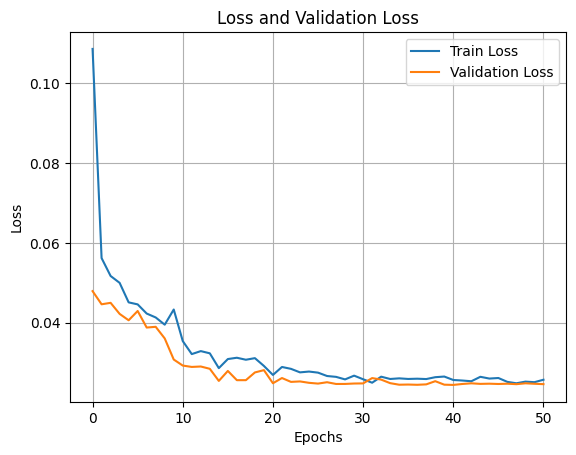

In [579]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=10,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    validation_data=(X_test, y_test),
)


plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [580]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

train_score = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_score = np.sqrt(mean_squared_error(y_test_inv, test_predict))

print(f'LSTM Train RMSE: {train_score}')
print(f'LSTM Test RMSE: {test_score}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM Train RMSE: 9.510564320684985
LSTM Test RMSE: 9.530235486516787


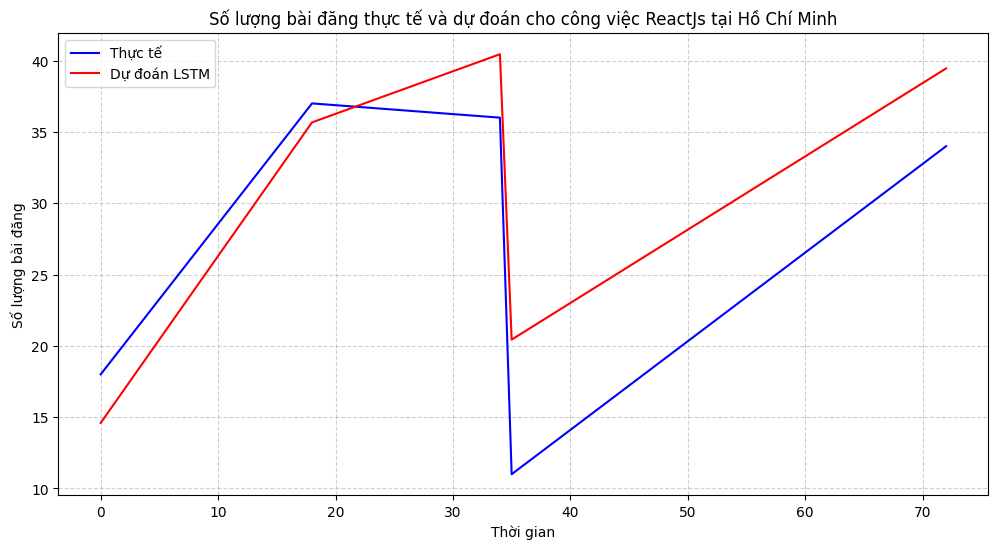

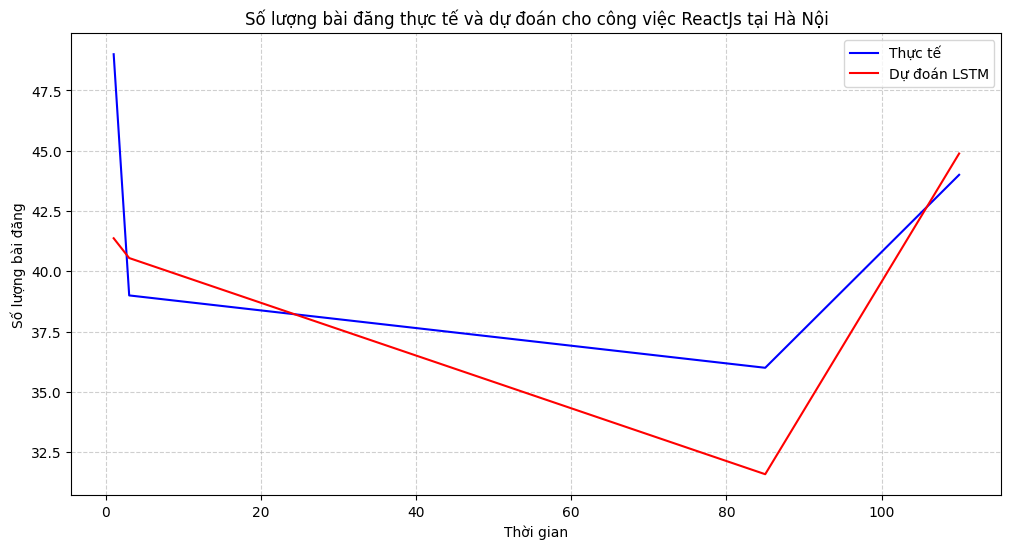

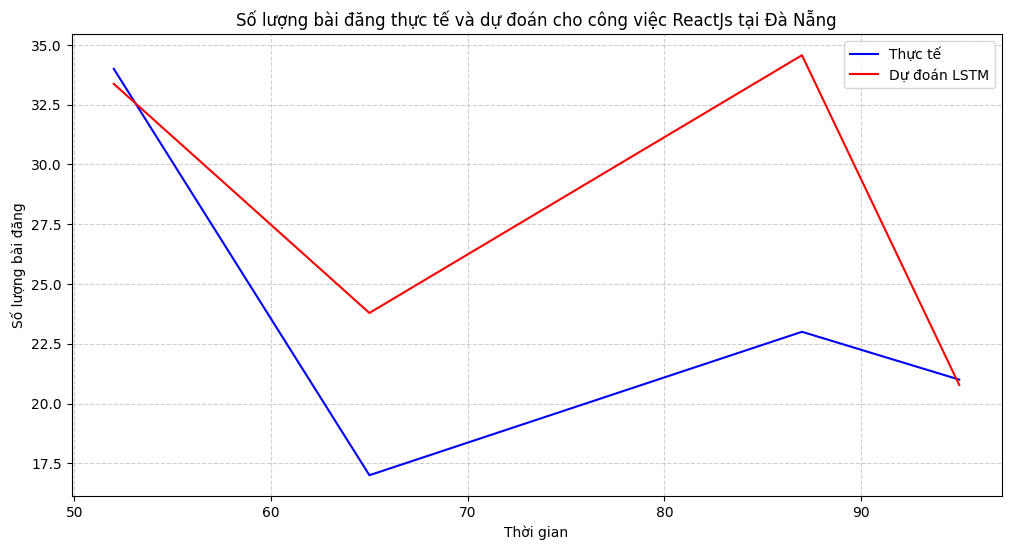

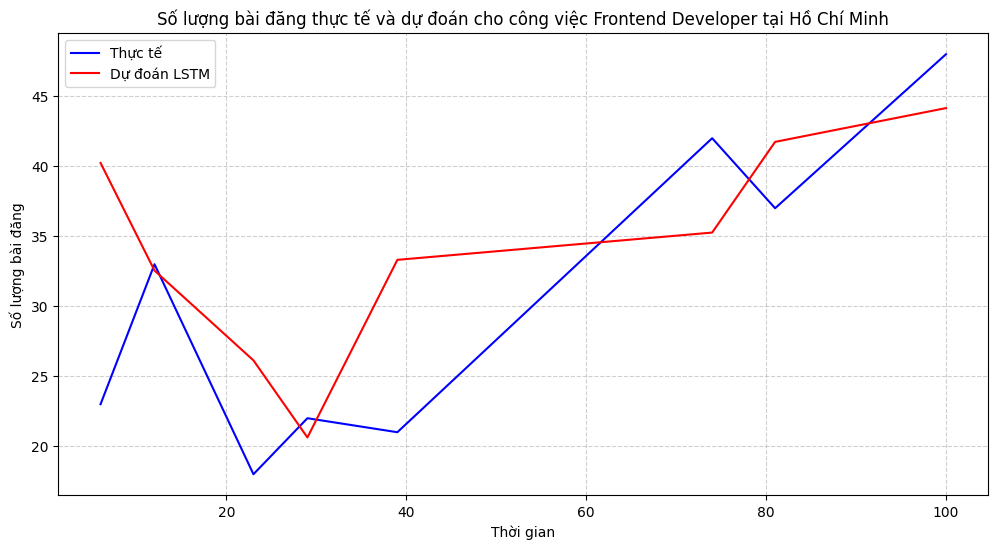

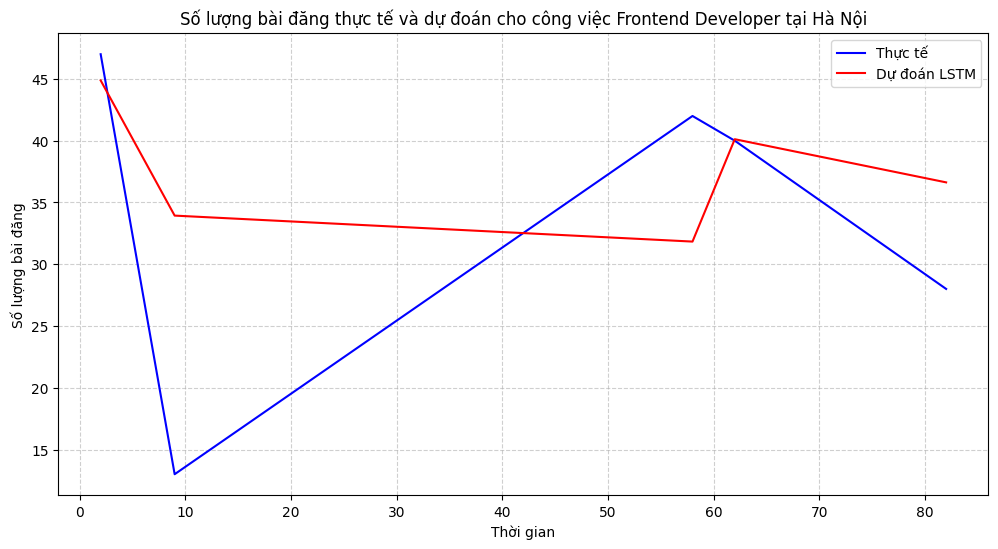

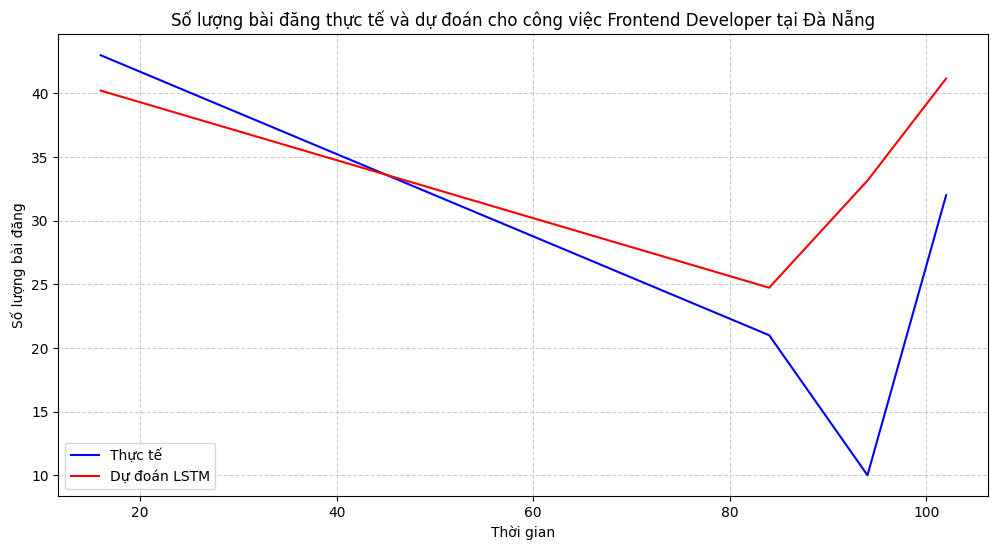

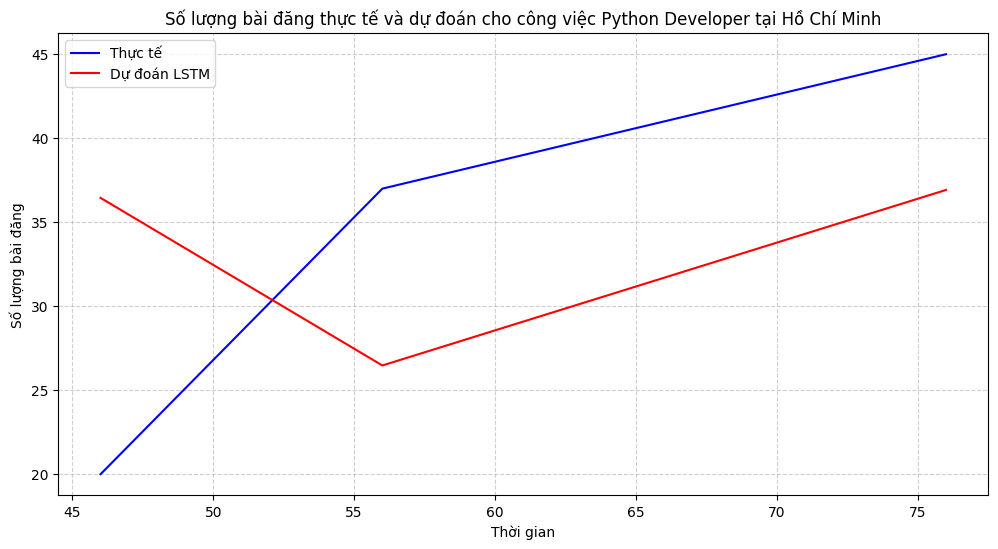

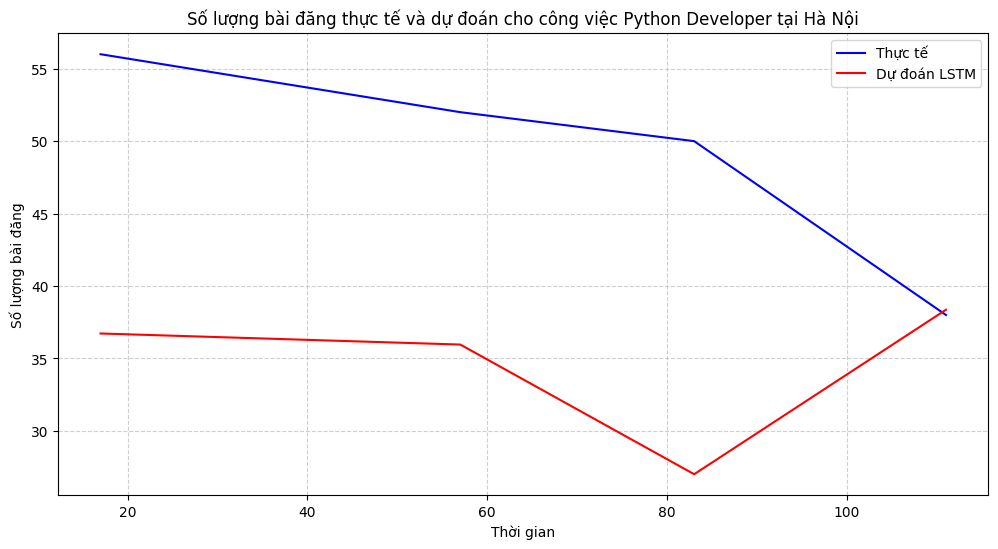

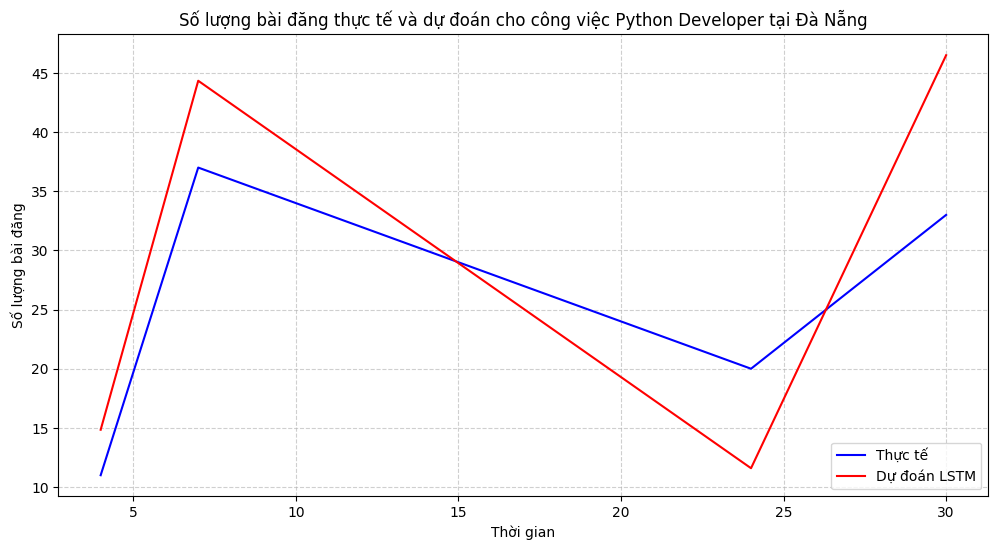

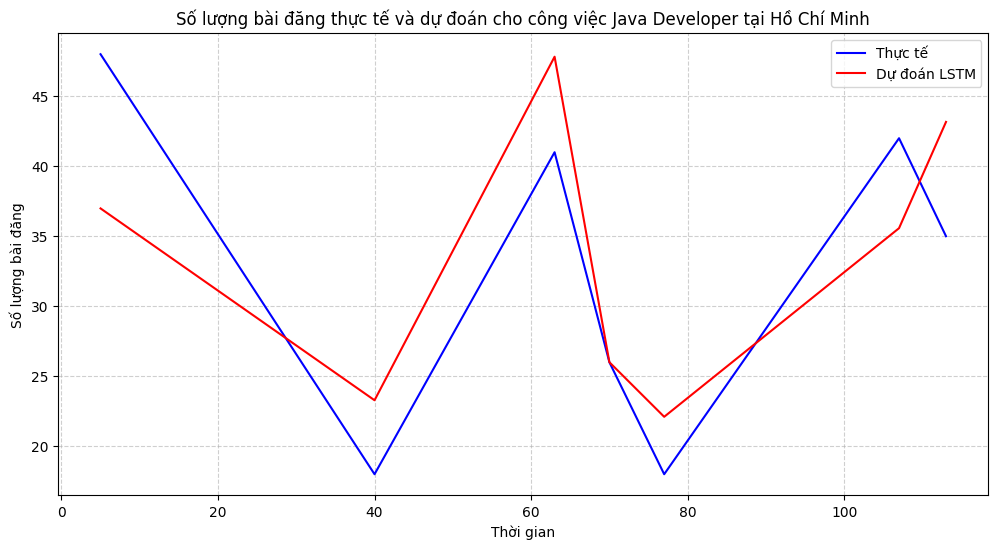

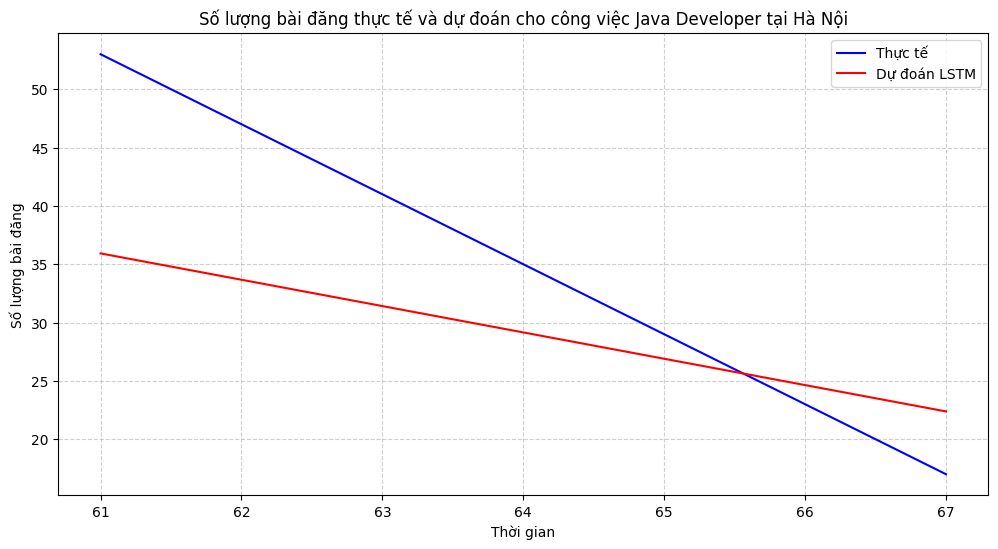

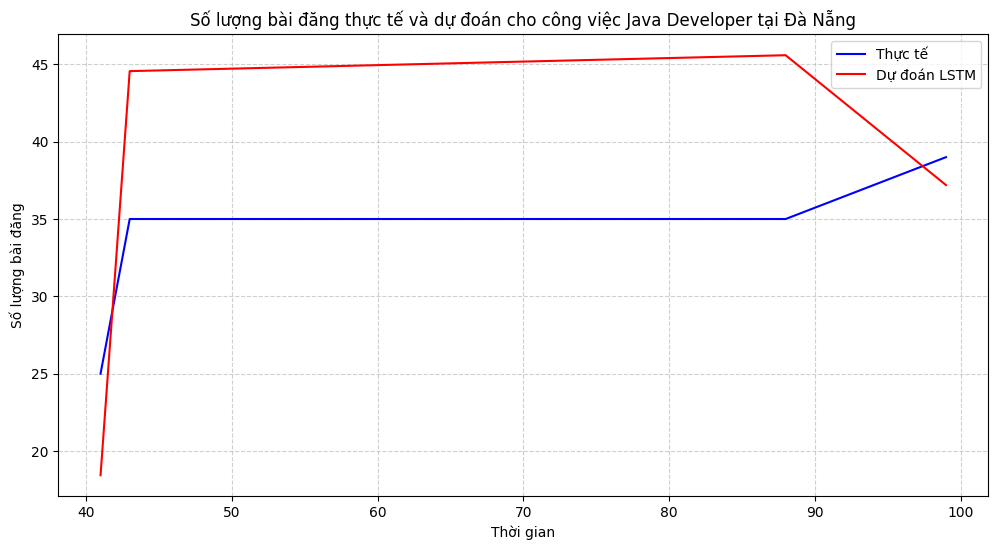

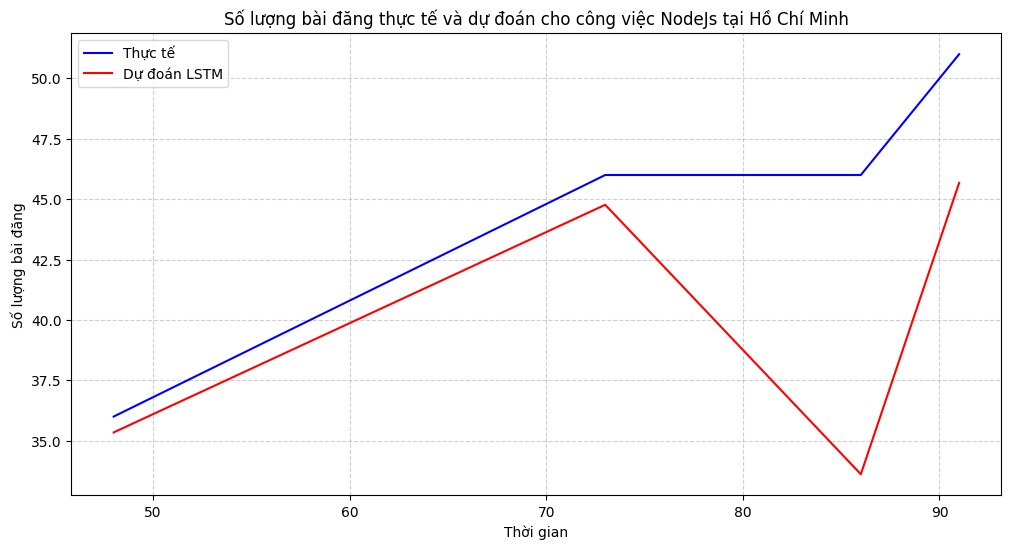

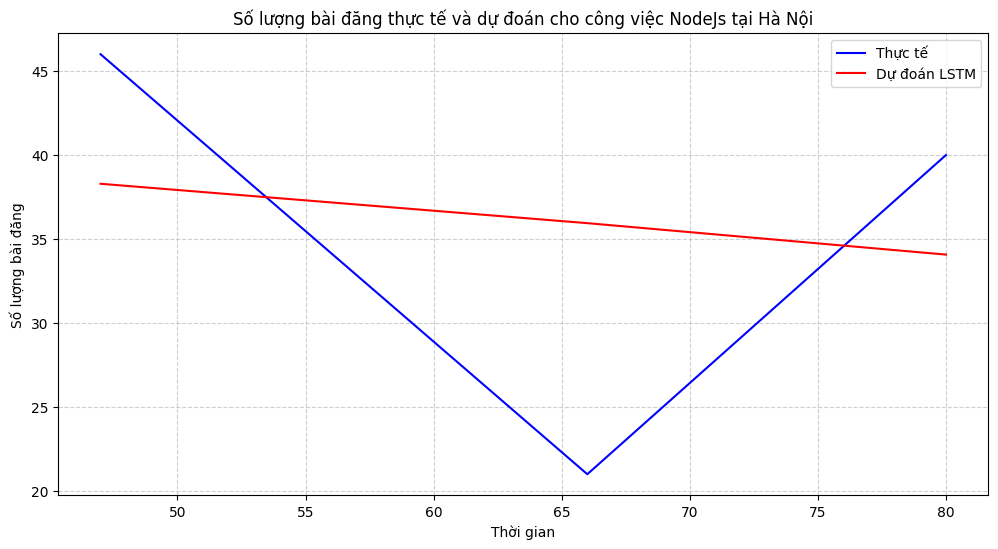

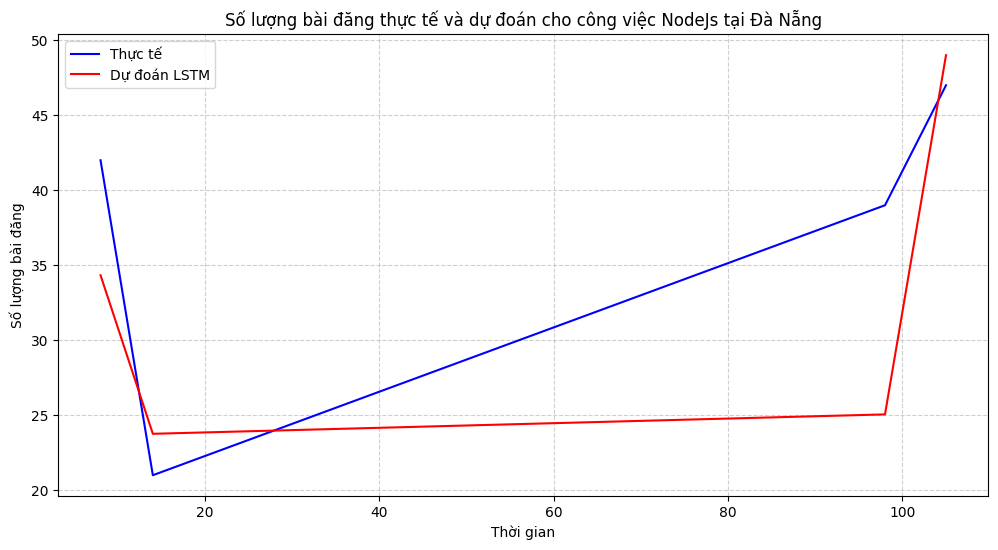

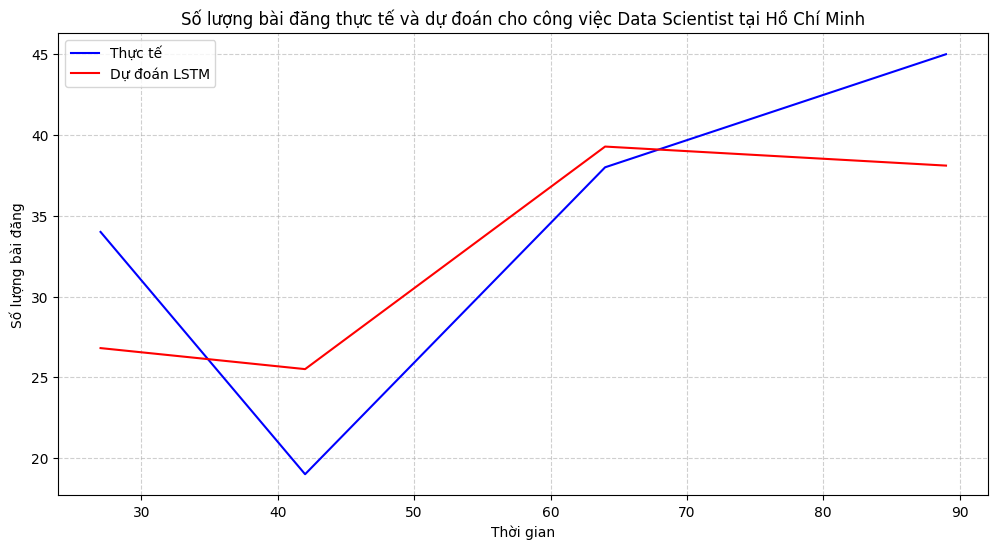

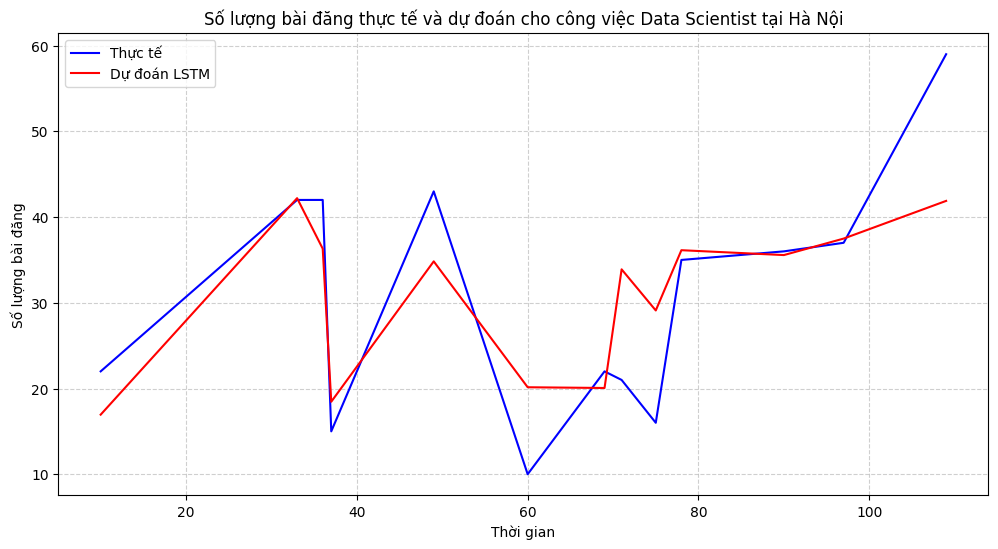

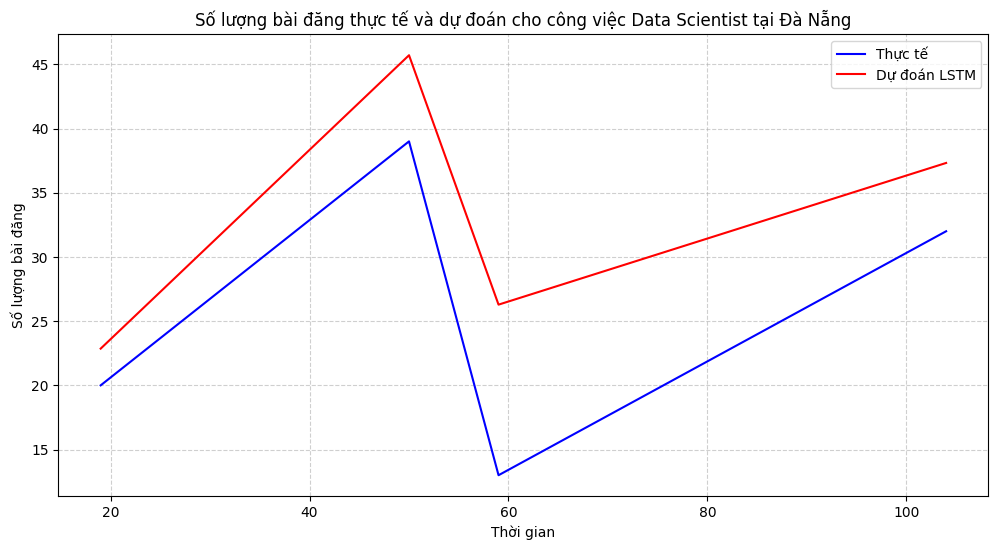

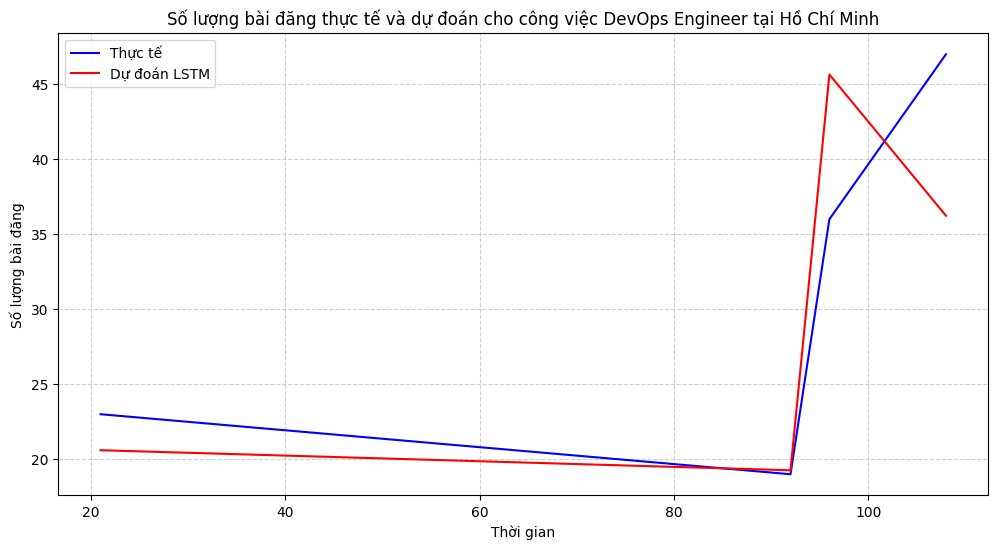

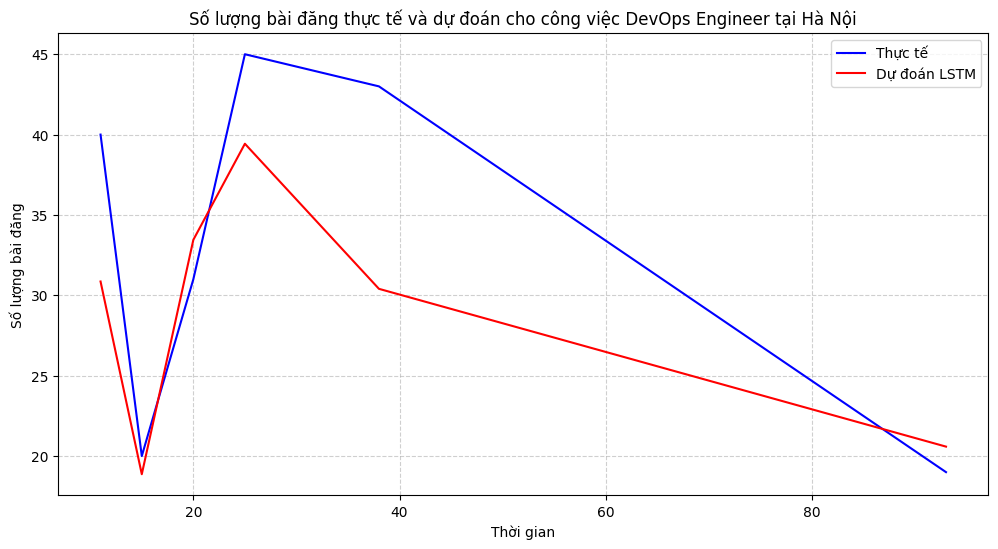

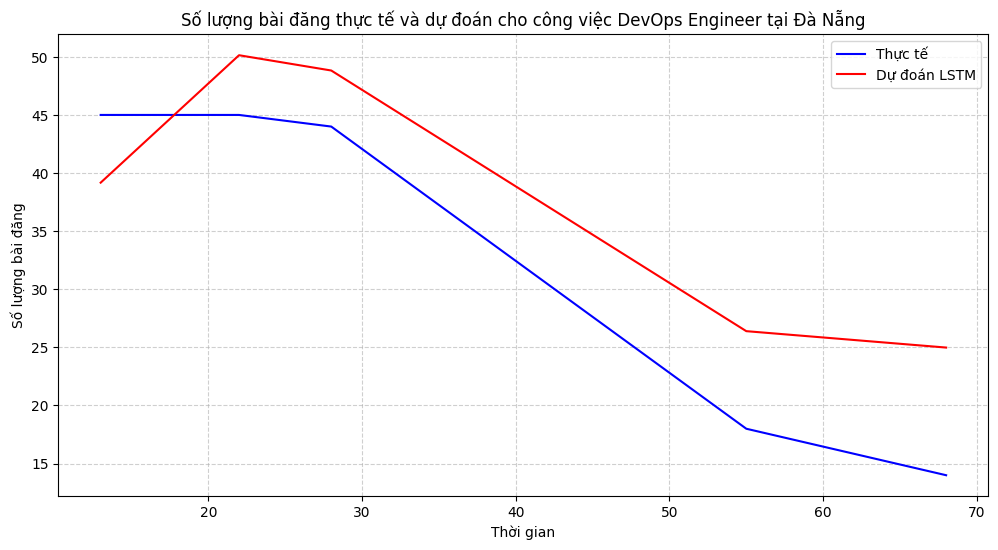

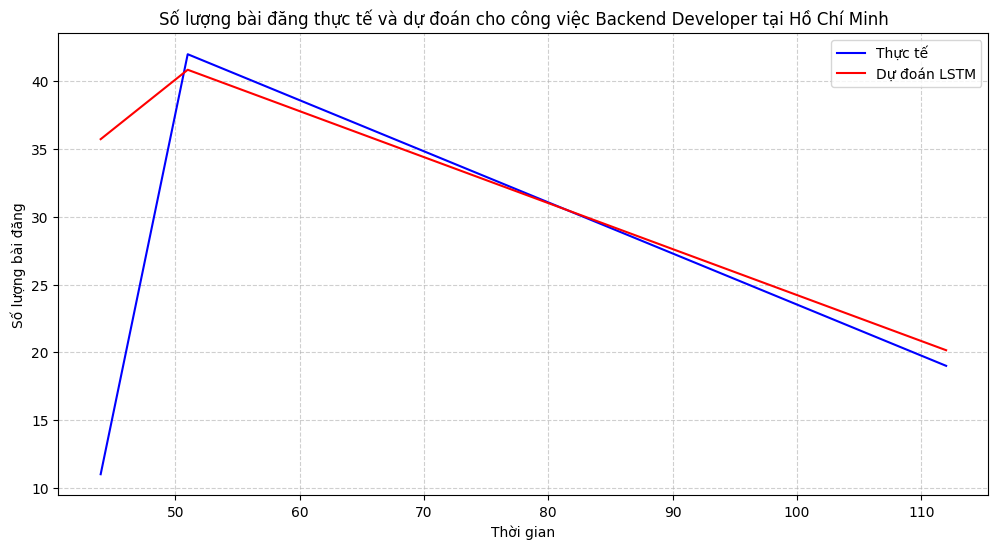

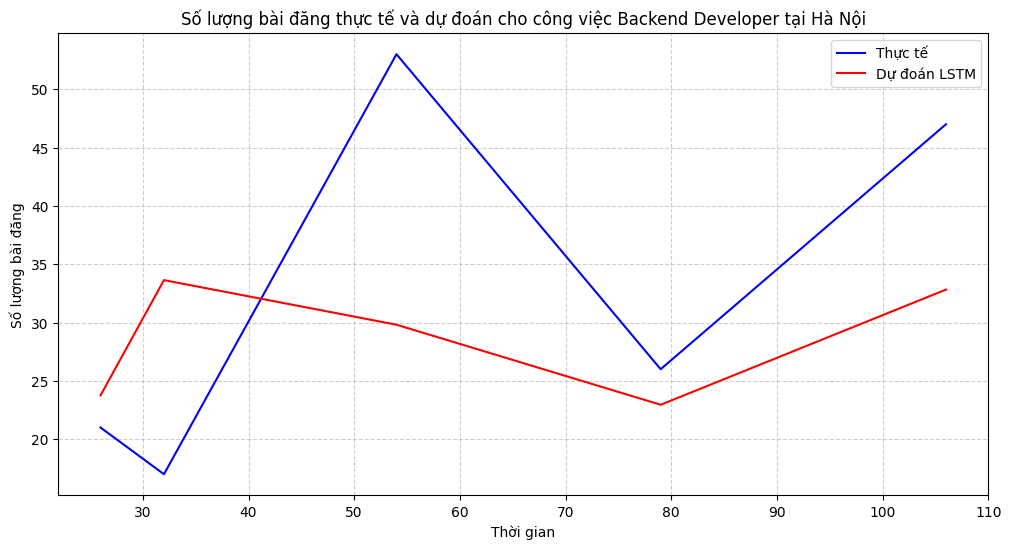

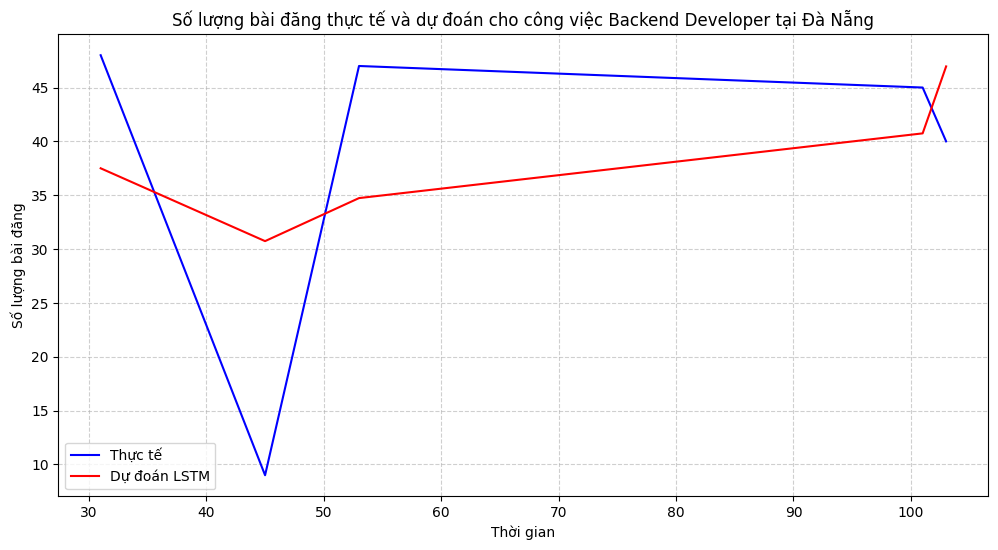

In [581]:
# Function to plot actual and predicted values for each job and city in the test set
def plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder):
    job_encoded = X_test[:, 0, 0]
    city_encoded = X_test[:, 0, 1]

    # Create a DataFrame for the test data with job and city information
    test_data = pd.DataFrame({
        'job_encoded': job_encoded,
        'city_encoded': city_encoded,
        'actual': y_test_inv.flatten(),
        'predicted': test_predict.flatten()
    })
    test_data['job'] = job_encoder.inverse_transform(test_data['job_encoded'].astype(int))
    test_data['city'] = city_encoder.inverse_transform(test_data['city_encoded'].astype(int))

    unique_jobs = test_data['job'].unique()
    unique_cities = test_data['city'].unique()

    for job in unique_jobs:
        for city in unique_cities:
            job_city_data = test_data[(test_data['job'] == job) & (test_data['city'] == city)]
            if len(job_city_data) > 0:
                plt.figure(figsize=(12, 6))
                plt.plot(job_city_data.index, job_city_data['actual'], label='Thực tế', color='blue')
                plt.plot(job_city_data.index, job_city_data['predicted'], label='Dự đoán LSTM', color='red')
                plt.xlabel('Thời gian')
                plt.ylabel('Số lượng bài đăng')
                plt.title(f'Số lượng bài đăng thực tế và dự đoán cho công việc {job} tại {city}')
                plt.legend()
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.show()
            else:
                print(f"Không có dữ liệu cho công việc {job} tại {city}")

# Plot predictions for each job and city in the test set
plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder)

In [588]:
model.save("../model/lstm_job_postings_model.keras")
print("Model saved to lstm_job_postings_model.keras")

Model saved to lstm_job_postings_model.keras


In [589]:
# Predict future job postings for a specific job and city
def predict_future(job, city, time_step=12, future_periods=12):
    job_encoded = job_encoder.transform([job])[0]
    city_encoded = city_encoder.transform([city])[0]
    x_input = aggregated_data[(aggregated_data['job'] == job) & (aggregated_data['city'] == city)]['job_postings_count_scaled'].values[-time_step:]

    # Append job_encoded and city_encoded as features
    x_input = np.array([np.append([job_encoded, city_encoded], x) for x in x_input.reshape(-1, 1)])

    temp_input = x_input.tolist()
    lst_output = []

    for i in range(future_periods):
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape(1, time_step, len(features))
            yhat = model.predict(x_input, verbose=0)
            next_input = [job_encoded, city_encoded, yhat[0][0]]
            temp_input.append(next_input)
            lst_output.append(yhat[0][0])
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape(1, len(temp_input), len(features))
            yhat = model.predict(x_input, verbose=0)
            next_input = [job_encoded, city_encoded, yhat[0][0]]
            temp_input.append(next_input)
            lst_output.append(yhat[0][0])

    # Inverse transform the predictions
    future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
    return future_predict

# Predict future job postings for ReactJs in Hanoi
future_predictions = predict_future('Data Scientist', 'Hồ Chí Minh', time_step, 3)
print(future_predictions)

[[26.807825]
 [31.442457]
 [35.95429 ]]
